# Imports

In [19]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from src.data.tiny_imagenet_dataset import SmallImageNetTrainDataset

# Data

In [20]:
image_size = 512


In [21]:
transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SmallImageNetTrainDataset(
        root_dir=r"F:\\research\data\\small_imagenet_object_loc\\train",
        classes_names_path=r"F:\\research\\data\\small_imagenet_object_loc\\classes_names.txt",
        transform=transform
)

In [22]:
sample = dataset[2390]
image = sample["image"]
label = sample["label_encoded"]
image_tag = sample["tag"]

In [23]:
image.shape, label


(torch.Size([3, 512, 512]), 23)

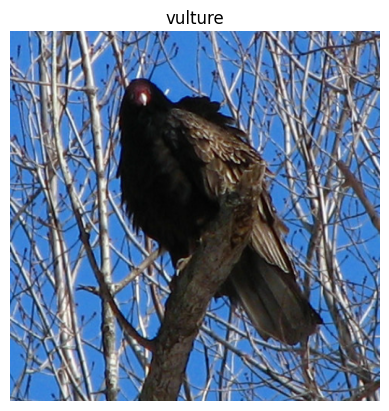

In [24]:
plt.title(f"{dataset.classes_names[image_tag]}")
plt.axis('off')
plt.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap="gray" if image.shape[0] == 1 else None)

# Wavelet

In [25]:
def dwt_haar(image):
    """
    Выполняет дискретное вейвлет-преобразование Хаара для входного RGB-изображения.
    
    Параметры:
      image: тензор формы (B, C, H, W), где B – размер батча, C – число каналов (3 для RGB),
             H и W – высота и ширина изображения.
    
    Возвращает:
      Тензор с коэффициентами вейвлет-преобразования формы (B, C, 4, H//2, W//2),
      где для каждого канала вычислены коэффициенты: [LL, LH, HL, HH].
    """
    # Масштабный коэффициент (нормировка)
    norm = 1.0 / 2.0  # можно интерпретировать как 1/sqrt(2)**2, если включить sqrt2 отдельно
    
    # Определяем фильтры для вейвлет Хаара
    # Фильтр LL (низкие частоты по горизонтали и вертикали)
    ll = torch.tensor([[1, 1],
                       [1, 1]], dtype=torch.float32) * norm

    # Фильтр LH (низкие частоты по горизонтали, высокие по вертикали)
    lh = torch.tensor([[-1, -1],
                       [ 1,  1]], dtype=torch.float32) * norm

    # Фильтр HL (высокие частоты по горизонтали, низкие по вертикали)
    hl = torch.tensor([[-1,  1],
                       [-1,  1]], dtype=torch.float32) * norm

    # Фильтр HH (высокие частоты по горизонтали и вертикали)
    hh = torch.tensor([[ 1, -1],
                       [-1,  1]], dtype=torch.float32) * norm

    # Собираем фильтры в один тензор
    # Форма фильтра: (4, 2, 2)
    filters = torch.stack([ll, lh, hl, hh], dim=0)
    
    # Для работы свёртки с группами: приводим фильтры к форме (out_channels, in_channels_per_group, kernel_h, kernel_w)
    # Мы хотим использовать один и тот же набор фильтров для каждого канала, поэтому расширяем размерность для in_channels
    filters = filters.unsqueeze(1)  # (4, 1, 2, 2)
    
    # Пусть число каналов C; повторяем фильтр для каждого канала
    C = image.shape[1]
    filters = filters.repeat(C, 1, 1, 1)  # (4*C, 1, 2, 2)
    
    # Выполняем свёртку по каждому каналу независимо (groups=C)
    # Результат будет иметь форму (B, 4*C, H//2, W//2)
    coeffs = F.conv2d(image, filters, stride=2, groups=C)
    
    # Меняем форму тензора, чтобы отдельно выделить коэффициенты вейвлета для каждого канала:
    # (B, C, 4, H//2, W//2)
    B, _, H_new, W_new = coeffs.shape
    coeffs = coeffs.view(B, C, 4, H_new, W_new)
    
    return coeffs

In [29]:
coeffs = dwt_haar(image.unsqueeze(0))

In [31]:
coeffs.shape

torch.Size([1, 3, 4, 256, 256])